# <center> RESPIRATION RATE ESTIMATION
 
 **08/02/2023**   
    
 **Group 7:** **Giovanni Zago**, **Enrico Lupi**, **Emanuele Sarte**, **Alessio Saccomani** 
 
   In this project we want to estimate the respiration rate using Seismocardiography(SCG), a technique used to measure Respiratory Rate and Hearth Rate using a detector positioned above sternum. We use also Ballistocardiography (BCG) in which there is no contact between the sensor and the body (in our case we have chosen the measures with the sensor....). The measures are provided by (221e: https://www.221e.com) using the platform MuSe (Multi-sensor miniaturized, low-power, wireless IMU. IMU stands for Inertial Measurement Unit. An IMU sensor is a combination of an accelerometer and a gyroscope sensor. It is used to detect movements and measure the intensity of movements in terms of acceleration and rotational speeds. Sometimes, like in this dataset, also magnetometer is included. 

In [210]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.221e.com/wp-content/uploads/2022/10/221e-Muse1.jpg", width=400, height=300)



In [211]:
Image(url= "https://embeddedinventor.com/wp-content/uploads/2019/07/imu1.jpg?ezimgfmt=ng:webp/ngcb7")

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import fftpack
from scipy import signal
import seaborn as sns

Firstly we import the libraries we're going to use (pandas, numpy, matplotlib, scipy, ecc.).
Then, we download the datafile 'center_sternum.txt' into a pandas dataframe . We consider every measurment taken every 0.005 s (frequency is 200 Hz). We decide to take care of the linear acceleration (in g), the angular velocity (in degree per second) and the magnetic field (in mgauss) in all three the directions. The quaternions are not considered, so we drop them. After that we calibrate the measures with the calibration in the file README_5.txt (also adding the offset) and we add an absolute time column to the dataset (every measure is taken in 0.005 s). 

In [213]:
file_name="center_sternum.txt"
data=pd.read_csv(file_name, "\t")

C:\Users\sacco\Downloads\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [214]:
freqs = data["Log Freq"].unique()
freq = np.bincount(freqs).argmax()
dt = 1.0/freq   #We controlled that every measure is 200 Hz and then calculate dt=1/200


# Calibration of the acceleration, gyroscope, magnetometer

gyro_offset = np.array([-2.804399,1.792105,0.3411708])

acc_calibration = np.array([[1.002982,9.415505e-5,0.004346743],
                    [9.04459e-5,1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_calibration = np.array([[1.013437,-0.04728858, -0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098, 74.62431, 630.9805])

data[['GyroX','GyroY','GyroZ']] = data[['GyroX','GyroY','GyroZ']] + gyro_offset.T
data[['AccX','AccY','AccZ']] = np.dot(data[['AccX','AccY','AccZ']],acc_calibration.T) + acc_offset.T
data[['MagnX','MagnY','MagnZ']] = np.dot(data[['MagnX','MagnY','MagnZ']],magn_calibration.T) + magn_offset.T

initial_time=data.loc[0, "Timestamp"]
data["Abs Time"] = np.arange(len(data))*0.005

labels=["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
Nvar = len(labels)
data=data.drop(["Log Mode","qw", "qi", "qj", "qk"], axis=1)  #We drop this columns of data
data

Log Freq   Timestamp        AccX        AccY        AccZ      GyroX  \
0           200  1576222772  953.860976  415.868858  131.257585  -9.628827   
1           200  1576222772  976.083597  367.828740  150.219623   3.378807   
2           200  1576222772  996.534818  360.382888  139.883473   8.905521   
3           200  1576222772  961.767494  398.166871  149.548076  15.073461   
4           200  1576222772  979.071817  407.877265  161.490470  22.416971   
...         ...         ...         ...         ...         ...        ...   
16501       200  1576222847  964.745350  271.085490    2.766861  -1.140277   
16502       200  1576222847  960.910755  268.020117    7.532365  -1.323483   
16503       200  1576222847  973.575040  270.488455   -7.063745  -1.689895   
16504       200  1576222847  971.896067  280.875609    0.772075  -2.102109   
16505       200  1576222847  966.206987  278.489246    1.002318  -2.514323   

           GyroY     GyroZ       MagnX       MagnY       MagnZ  Abs Time  
0     -12.452175  1.745751 -587.007451 -397.737874  459.781335     0.000  
1     -10.497975 -7.628295 -587.009313 -397.729651  460.725243     0.005  
2      -3.169727 -7.109211 -587.009313 -397.729651  460.725243     0.010  
3       4.311189 -5.643562 -586.916597 -399.731093  461.652707     0.015  
4       7.196685  4.356438 -586.916597 -399.731093  461.652707     0.020  
...          ...       ...         ...         ...         ...       ...  
16501   4.097449 -0.330585 -629.580560 -354.220667  509.276100    82.505  
16502   4.280655 -0.361119 -629.535133 -355.217276  510.211786    82.510  
16503   5.166151 -0.559593 -629.535133 -355.217276  510.211786    82.515  
16504   5.456227 -1.246615 -630.645008 -353.152102  511.173999    82.520  
16505   5.853174 -1.002340 -630.645008 -353.152102  511.173999    82.525  

[16506 rows x 12 columns]

Now, we plot the accelerations, the angular velocity and the magnetic field with respect to the time. In this way we have a first idea about the data, in particular we understand which windows of time is ideal to studying the dataset. We look for times where there's not anomalous variation of acceleration or velocity (maybe some movements of the body independent from the hearth rate, and respiration rate) that we do not want to consider. In the left column there is the entire measure and in the right column there is a zoom to see a smaller window of time

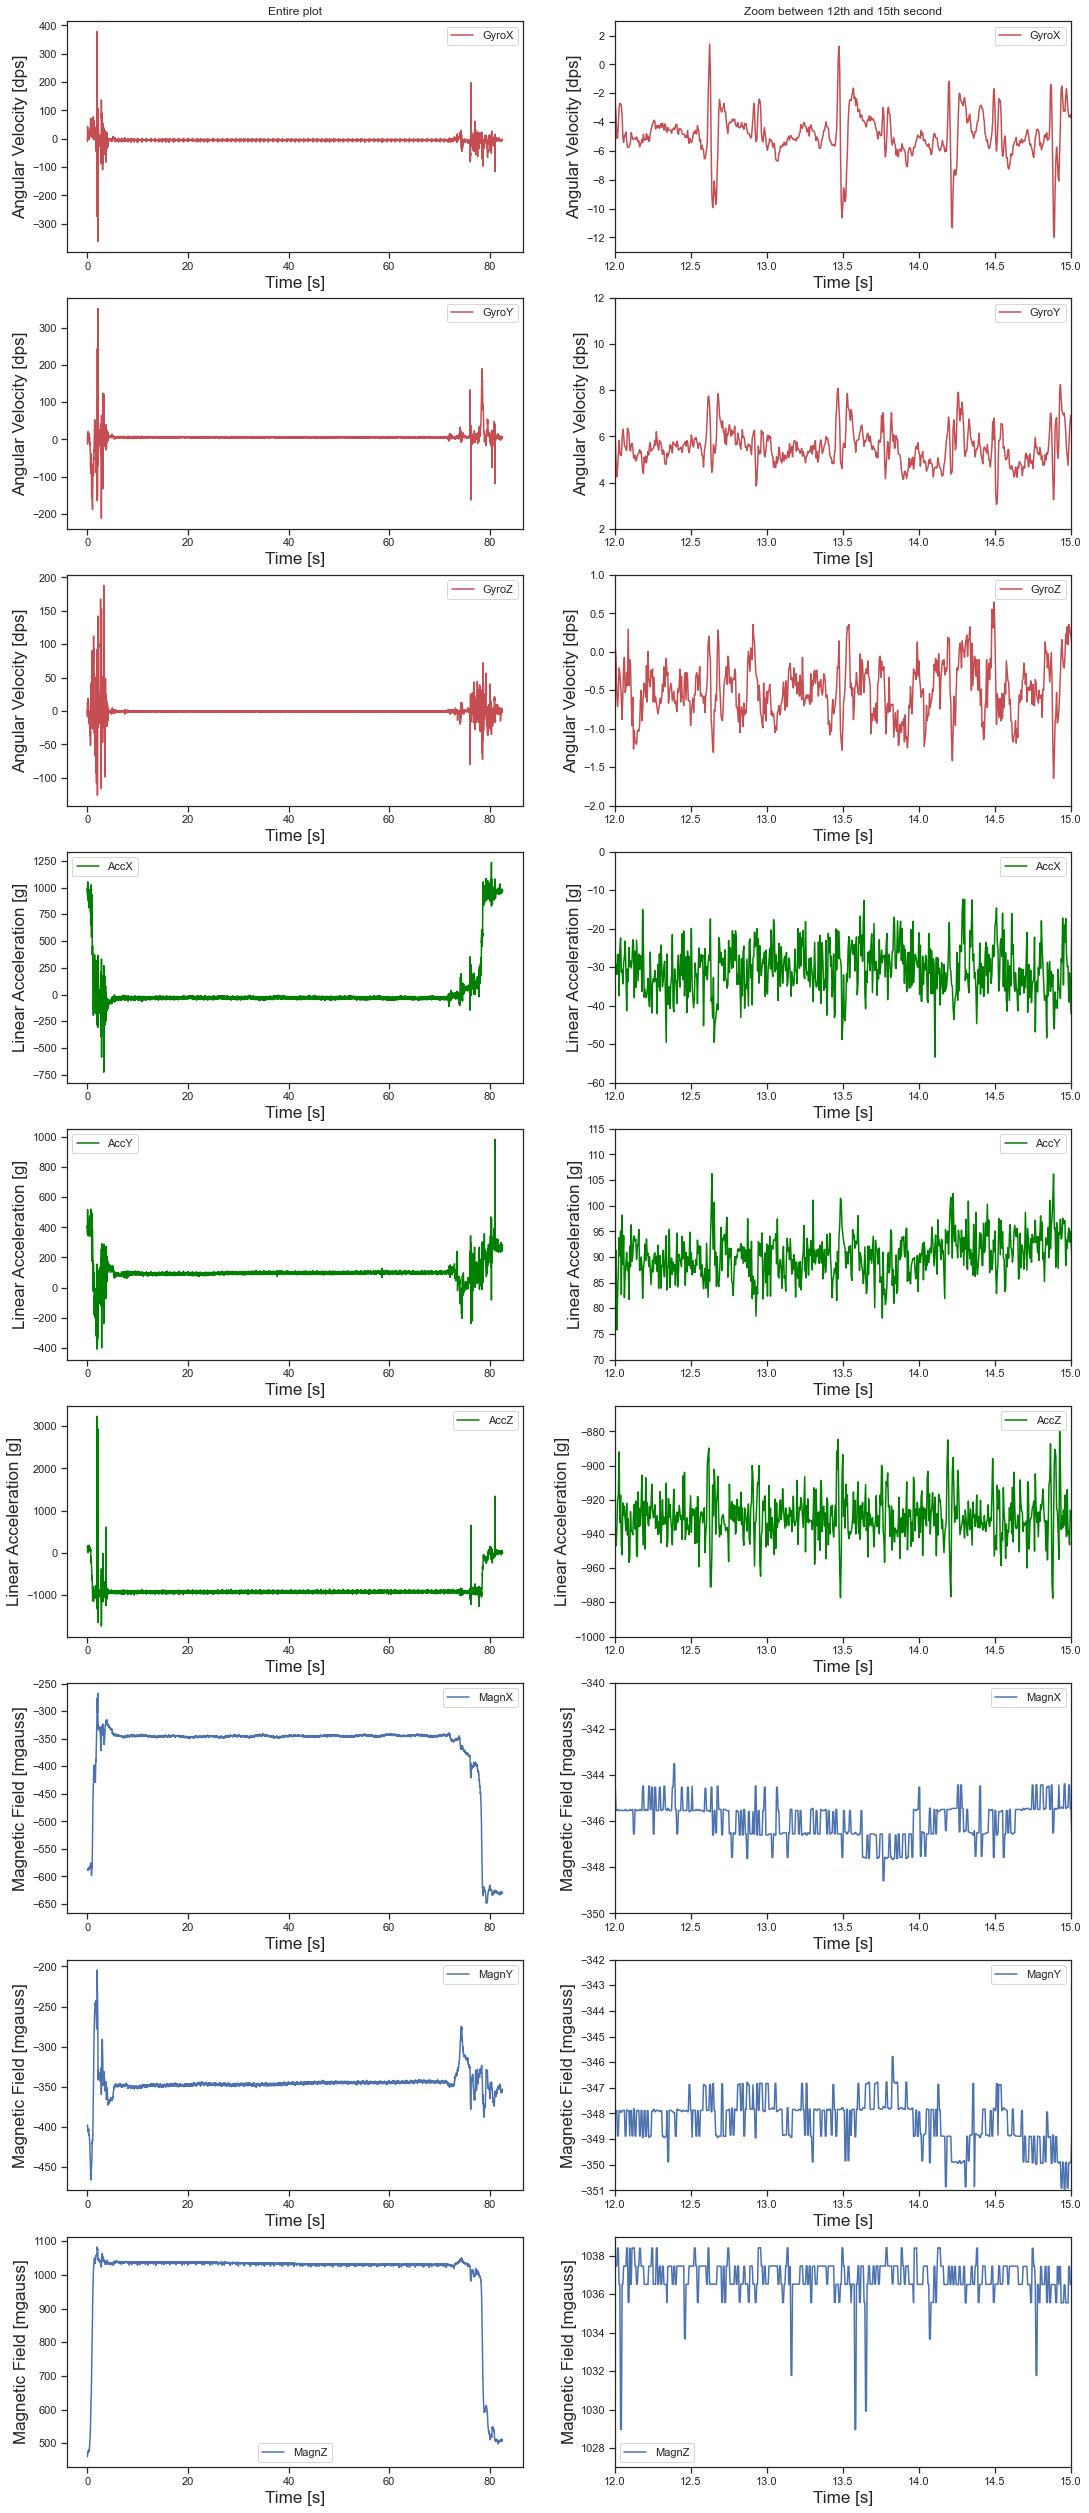

In [215]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))   #create a figure in which plotting the data

for i in range(2):
    for j in range(Nvar):
        if j<3:
            axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j], c='r')
        elif j>5:
            axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j], c='b')
        else:
            axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j], c='green')
        if i == 1:
            axs[j][i].set_xlim([12,15])  


axs[0][0].title.set_text('Entire plot')
axs[0][1].title.set_text('Zoom between 12th and 15th second')
axs[0][1].set_ylim([-13,3])
axs[1][1].set_ylim([2,12])
axs[2][1].set_ylim([-2,1])
axs[3][1].set_ylim([-60,-0])
axs[4][1].set_ylim([70,115])
axs[5][1].set_ylim([-1000,-865])
axs[6][1].set_ylim([-350,-340])
axs[7][1].set_ylim([-351,-342])
axs[8][1].set_ylim([1027,1039])

for i in range(2):
    for j in range(9):
        axs[j][i].set_xlabel("Time [s]", fontsize=17)
        if j<3:
            axs[j][i].set_ylabel('Angular Velocity [dps]', fontsize=17)
        elif j>5:
            axs[j][i].set_ylabel('Magnetic Field [mgauss]', fontsize=17)
        else:
            axs[j][i].set_ylabel('Linear Acceleration [g]', fontsize=17)
        axs[j][i].legend(loc="best")
        


Firstly, we see that from 10 seconds to 65 seconds all the measures have a constant behaviour, so we consider this to be the time window we're going to use in the rest of the project. Now we want to calculate some quantities to analyze these columns of data, mean, variance and correlations.

In [216]:
t1_cut = 10
t2_cut = 65

#We select the time window over which performing the analysis

data = data.drop(data.index[range(t2_cut*freq,len(data))])
data = data.drop(data.index[range(t1_cut*freq)])
data

Log Freq   Timestamp       AccX        AccY        AccZ     GyroX  \
2000        200  1576222781 -33.264892   93.627299 -928.302876 -1.048674   
2001        200  1576222781 -19.821167   93.103743 -946.600303 -1.247147   
2002        200  1576222781 -28.023284   91.289694 -918.469924 -1.873101   
2003        200  1576222781 -22.317938   94.649348 -914.866762 -1.857834   
2004        200  1576222781 -32.891861   98.906352 -898.008163 -1.781498   
...         ...         ...        ...         ...         ...       ...   
12995       200  1576222831 -32.417317   98.992852 -916.048352 -4.483788   
12996       200  1576222831 -41.260245   97.718394 -923.817175 -3.934170   
12997       200  1576222831 -33.673718   97.413246 -923.783858 -3.918903   
12998       200  1576222831 -25.896088   99.266833 -936.514323 -4.361651   
12999       200  1576222831 -43.153929  100.204817 -908.678614 -4.376918   

          GyroY     GyroZ       MagnX       MagnY        MagnZ  Abs Time  
2000   6.815006 -0.467990 -345.302915 -352.919796  1035.533844    10.000  
2001   5.990578 -0.742798 -345.302915 -352.919796  1035.533844    10.005  
2002   6.112716 -0.758066 -344.423897 -349.985477  1031.781018    10.010  
2003   5.929509 -0.926005 -344.423897 -349.985477  1031.781018    10.015  
2004   6.494395 -0.651196 -345.352065 -351.906741  1036.485974    10.020  
...         ...       ...         ...         ...          ...       ...  
12995  5.456227 -0.162646 -343.690469 -344.020218  1029.940672    64.975  
12996  5.807372 -0.177913 -343.690469 -344.020218  1029.940672    64.980  
12997  5.379891 -0.376386 -343.741480 -342.998941  1031.836710    64.985  
12998  5.731036 -0.300051 -343.741480 -342.998941  1031.836710    64.990  
12999  5.807372 -0.712264 -344.753056 -342.959875  1030.894664    64.995  

[11000 rows x 12 columns]

Now we print for all the columns remained the mean, standard deviation, minimum, maximum and the 25,50,75 percentiles in the time window we have selected. Then we also normalize the data by subtracting the mean and by dividing for the standard deviation. For the accelerations and the angular velocities the 25 and 75 percentiles are nearly simmetric, so the variables change quite regularly. We notice a higher deviation for the acceleration over X, and the angular velocity along Z 

In [217]:
#get statistical descriptors 
data_stat = data.describe()
data_stat

Log Freq     Timestamp          AccX          AccY          AccZ  \
count   11000.0  1.100000e+04  11000.000000  11000.000000  11000.000000   
mean      200.0  1.576223e+09    -31.165889     96.039560   -923.926548   
std         0.0  1.459514e+01      7.015152      5.350573     14.820895   
min       200.0  1.576223e+09    -67.589727     66.504422   -991.854221   
25%       200.0  1.576223e+09    -35.777400     92.476473   -932.679011   
50%       200.0  1.576223e+09    -31.069987     96.196779   -924.386908   
75%       200.0  1.576223e+09    -26.495908     99.564296   -916.003671   
max       200.0  1.576223e+09     -6.014217    128.109179   -852.064589   

              GyroX         GyroY         GyroZ         MagnX         MagnY  \
count  11000.000000  11000.000000  11000.000000  11000.000000  11000.000000   
mean      -4.881569      5.480324     -0.527151   -345.286311   -346.361287   
std        1.425450      0.717922      0.364963      1.324977      1.703691   
min      -12.804399      2.295922     -2.162646   -349.594967   -352.919796   
25%       -5.491422      5.074548     -0.773333   -346.505506   -347.848347   
50%       -4.957071      5.425693     -0.513791   -345.541219   -346.021659   
75%       -4.270048      5.792105     -0.284783   -344.527782   -344.961317   
max        1.668883      9.349357      0.982392   -340.606592   -341.860466   

              MagnZ      Abs Time  
count  11000.000000  11000.000000  
mean    1033.696011     37.497500  
std        2.721540     15.877854  
min     1022.383050     10.000000  
25%     1031.799323     23.748750  
50%     1033.695360     37.497500  
75%     1036.510640     51.246250  
max     1039.378974     64.995000

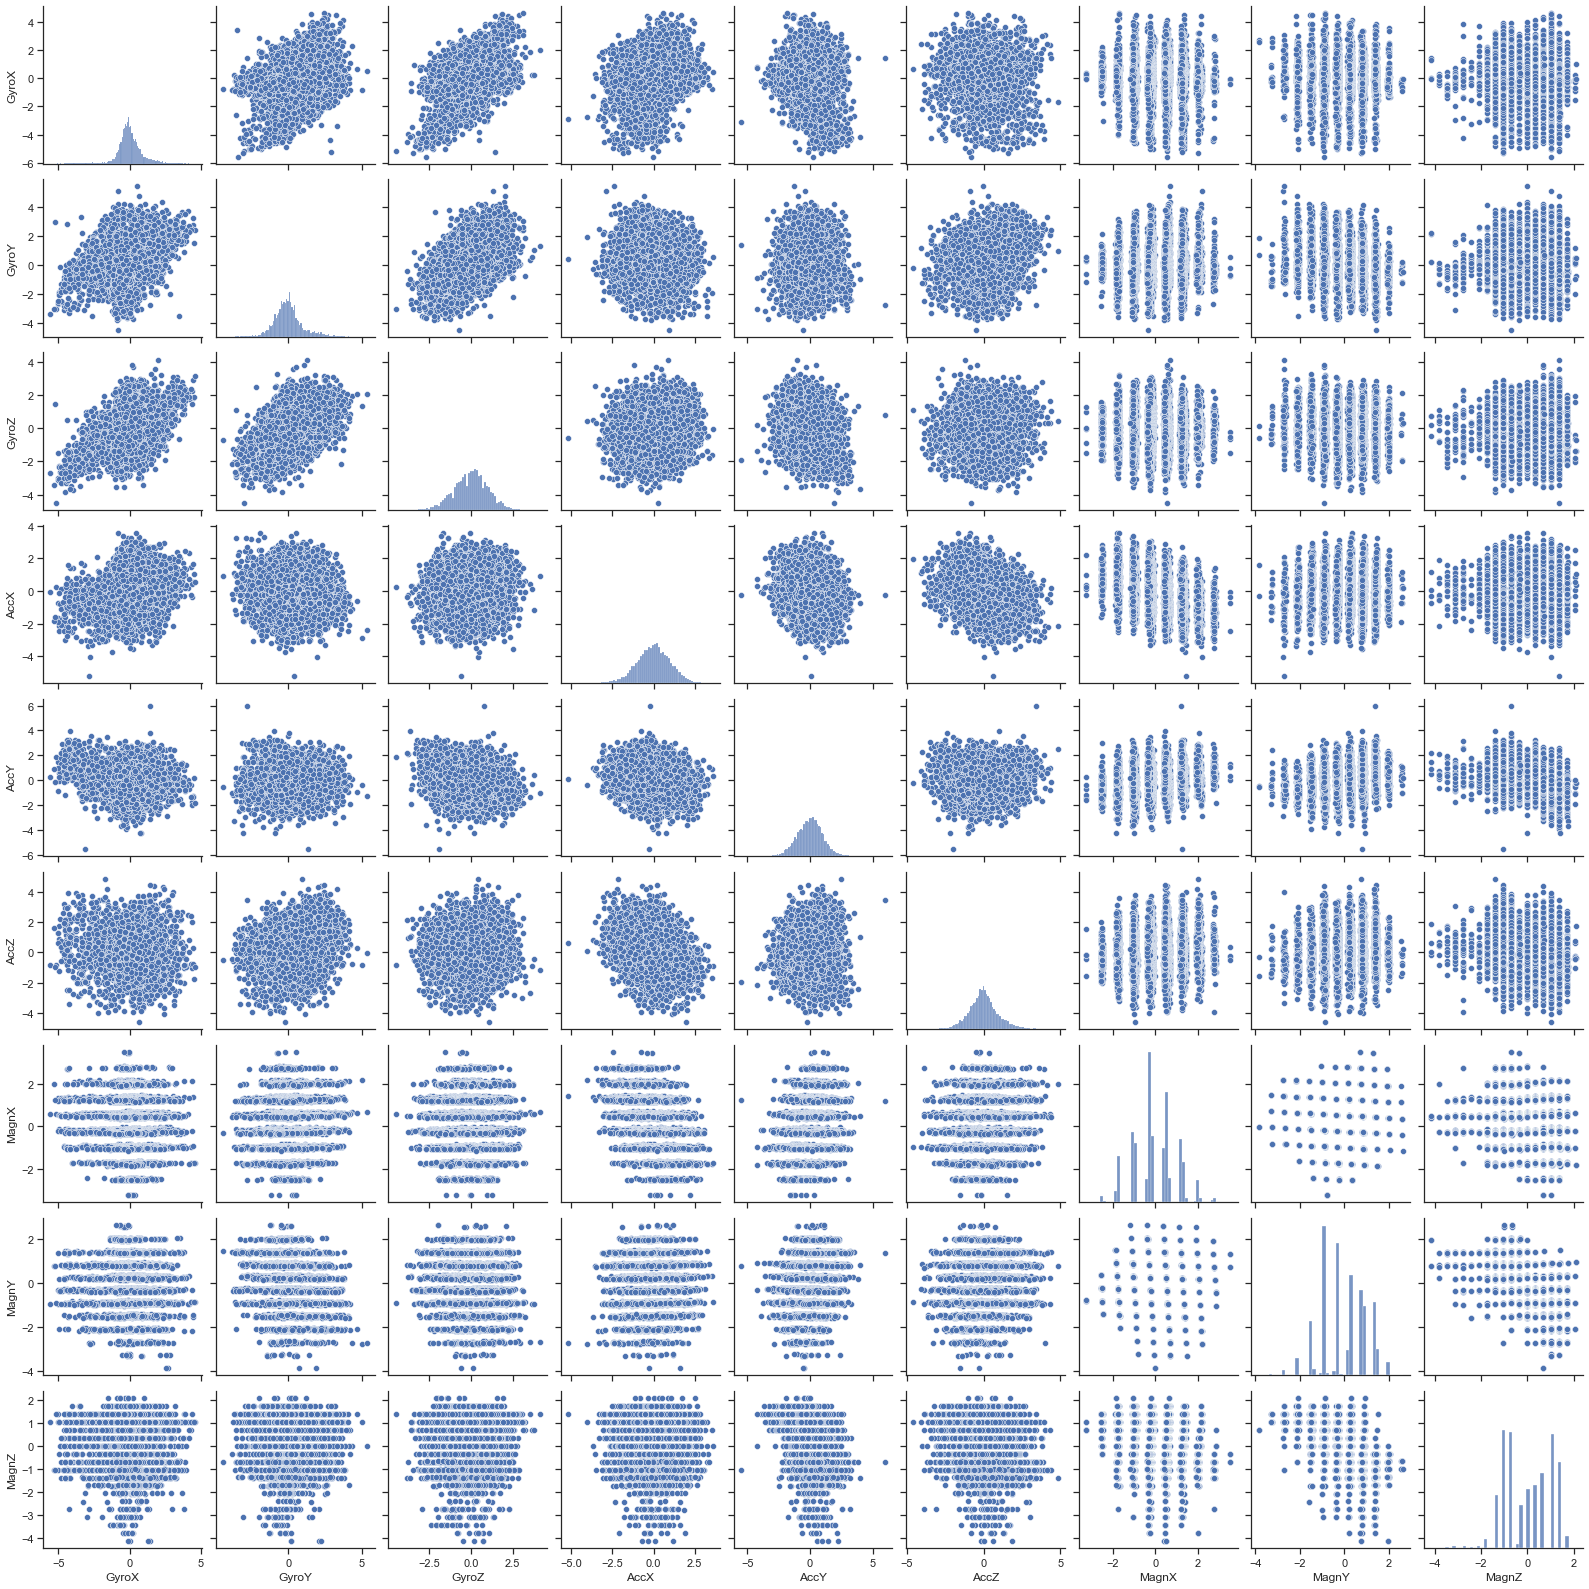

In [218]:
#set mean to zero to normalize the data
for l in labels:
    data[l]= (data[l]-data_stat.at["mean",l])/data_stat.at['std',l]

sns.set_theme(style="ticks")
sns.pairplot(data[labels])


In [198]:
data.describe()

grafico nove torte

Log Freq     Timestamp          AccX          AccY          AccZ  \
count   11000.0  1.100000e+04  1.100000e+04  1.100000e+04  1.100000e+04   
mean      200.0  1.576223e+09 -7.345962e-15  3.639190e-15 -1.195284e-13   
std         0.0  1.459514e+01  1.000000e+00  1.000000e+00  1.000000e+00   
min       200.0  1.576223e+09 -5.192167e+00 -5.519996e+00 -4.583237e+00   
25%       200.0  1.576223e+09 -6.573644e-01 -6.659263e-01 -5.905489e-01   
50%       200.0  1.576223e+09  1.367073e-02  2.938358e-02 -3.106156e-02   
75%       200.0  1.576223e+09  6.656992e-01  6.587586e-01  5.345748e-01   
max       200.0  1.576223e+09  3.585335e+00  5.993679e+00  4.848692e+00   

              GyroX         GyroY         GyroZ         MagnX         MagnY  \
count  1.100000e+04  1.100000e+04  1.100000e+04  1.100000e+04  1.100000e+04   
mean  -4.985845e-15 -1.562572e-14 -1.665630e-14 -1.183709e-12 -1.546713e-11   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -5.558126e+00 -4.435580e+00 -4.481262e+00 -3.251873e+00 -3.849587e+00   
25%   -4.278319e-01 -5.652092e-01 -6.745395e-01 -9.201635e-01 -8.728457e-01   
50%   -5.296711e-02 -7.609642e-02  3.660703e-02 -1.923870e-01  1.993484e-01   
75%    4.290021e-01  4.342819e-01  6.640887e-01  5.724846e-01  8.217280e-01   
max    4.595358e+00  5.389207e+00  4.136154e+00  3.531925e+00  2.641806e+00   

              MagnZ      Abs Time  
count  1.100000e+04  11000.000000  
mean   5.815973e-12     37.497500  
std    1.000000e+00     15.877854  
min   -4.156823e+00     10.000000  
25%   -6.969173e-01     23.748750  
50%   -2.391735e-04     37.497500  
75%    1.034204e+00     51.246250  
max    2.088142e+00     64.995000

Now we're going to perform a fourier analysis using the scipy fftpack library; in this way we would like to estrapolate the principal frequencies of the data and see if we can see a frequence near the respiratory rate (and also the hearth rate frequency). Firstly we calculate the power and the frequencies and we plot the power w.r.t. the frequency for every variable. In the left column we can see the entire spectrum (with both the respiration's and the hearth's frequencies) while in the right column there is a zoom in the [0,1] frequency

In [208]:
#perform Fourier analysis

sig_fft = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft[i] = fftpack.fft(data[labels[i]].values)

power = np.abs(sig_fft)
sample_freq = fftpack.fftfreq(len(data), d=dt)

sample_freq.shape

(11000,)

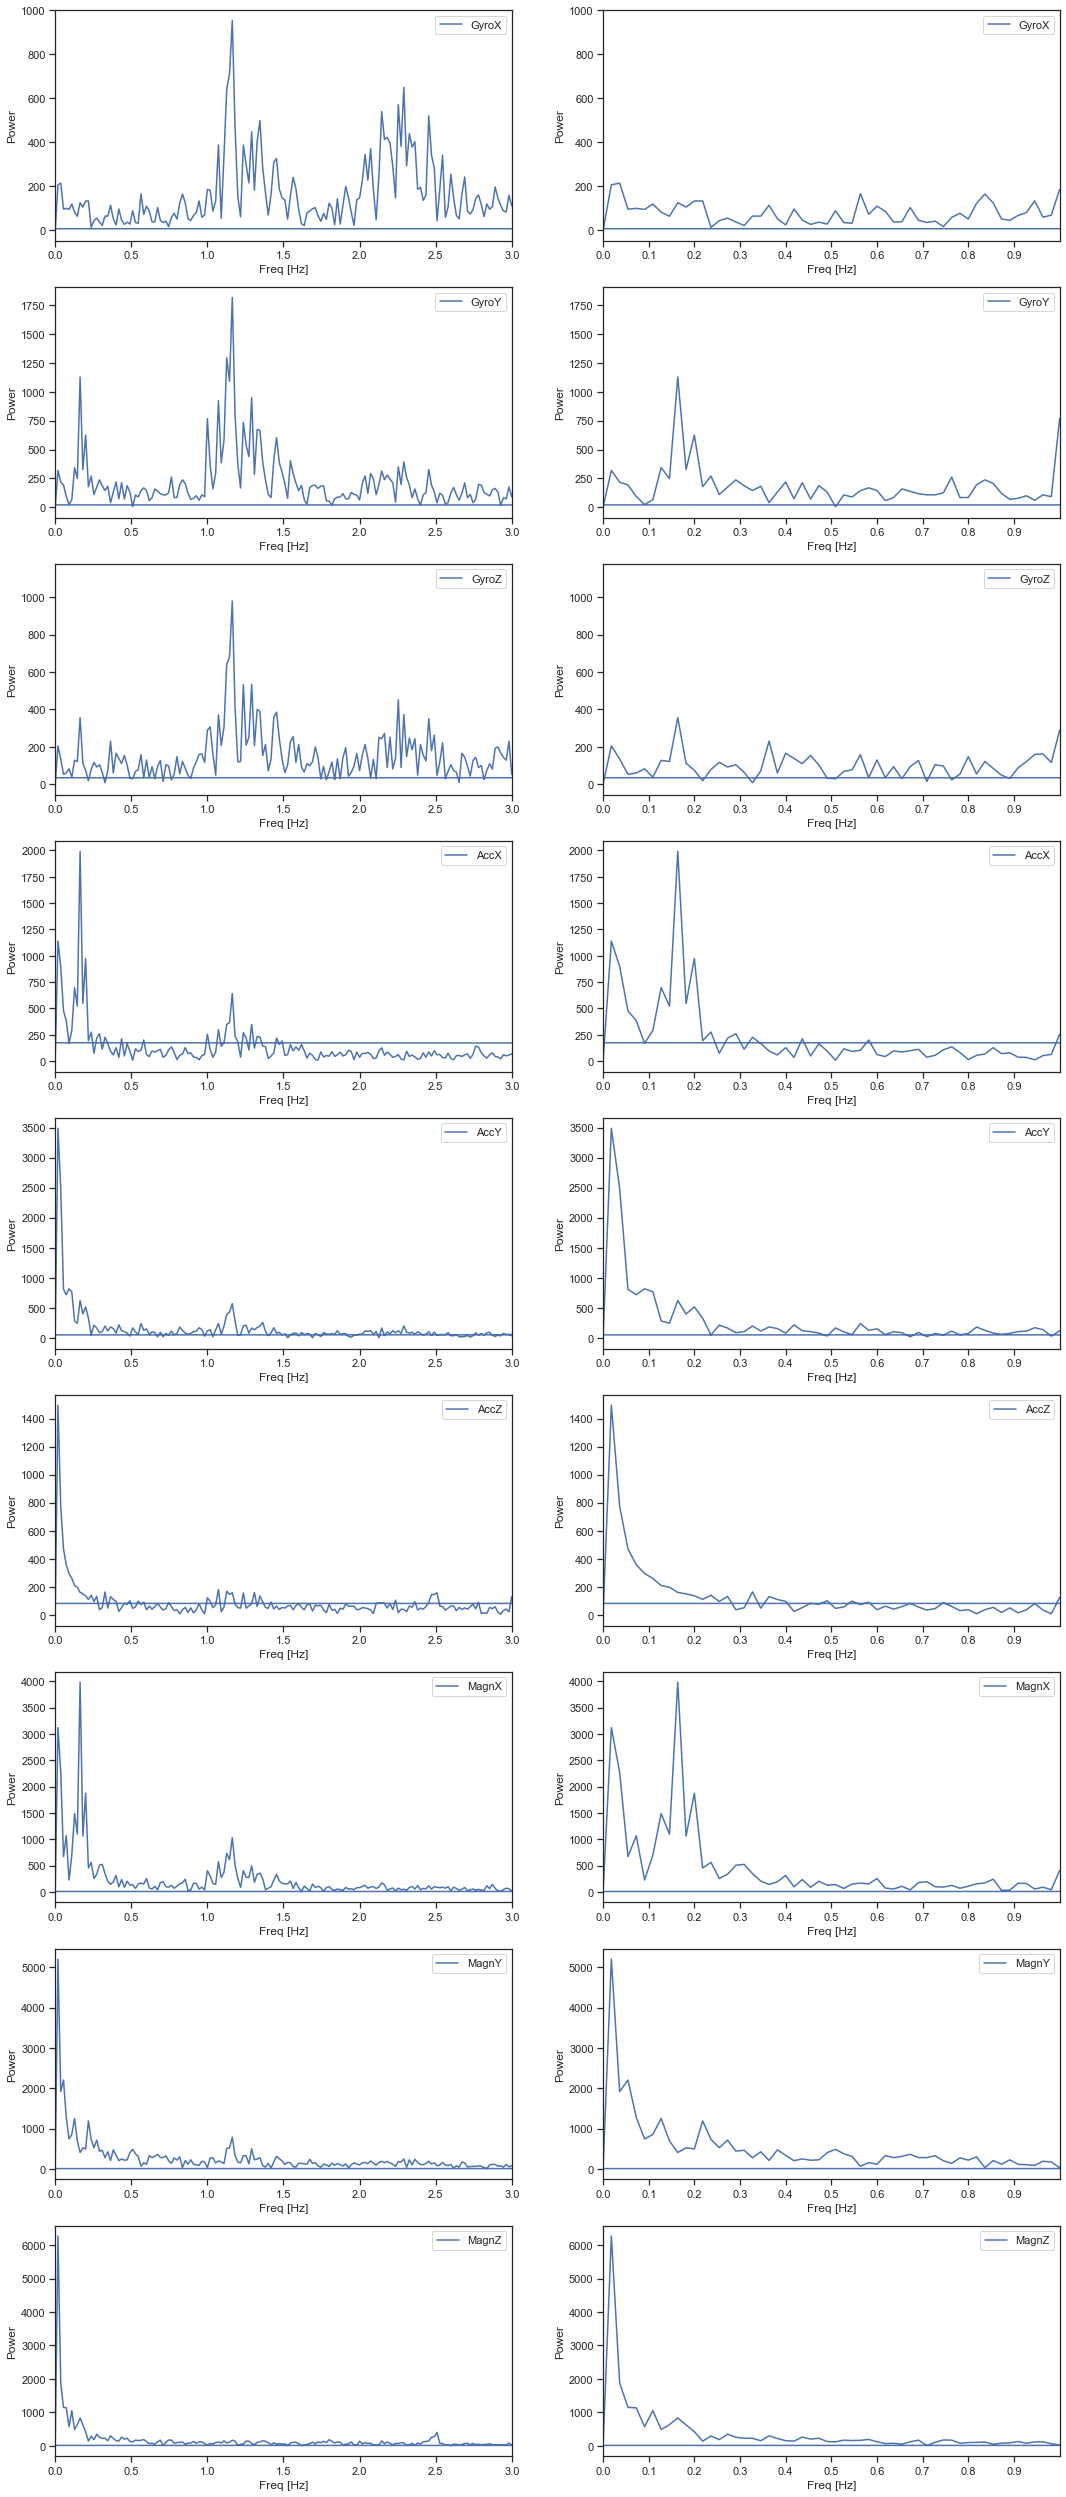

In [200]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j], label=labels[j])
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")
    
    


In [201]:
#filter signal with Butterworth bandpass filter in [0.1,0.9] Hz range

filtered = np.zeros((Nvar,len(data)))
sos = signal.butter(2, [0.1,0.8], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data[labels[i]])

(11000, 9)

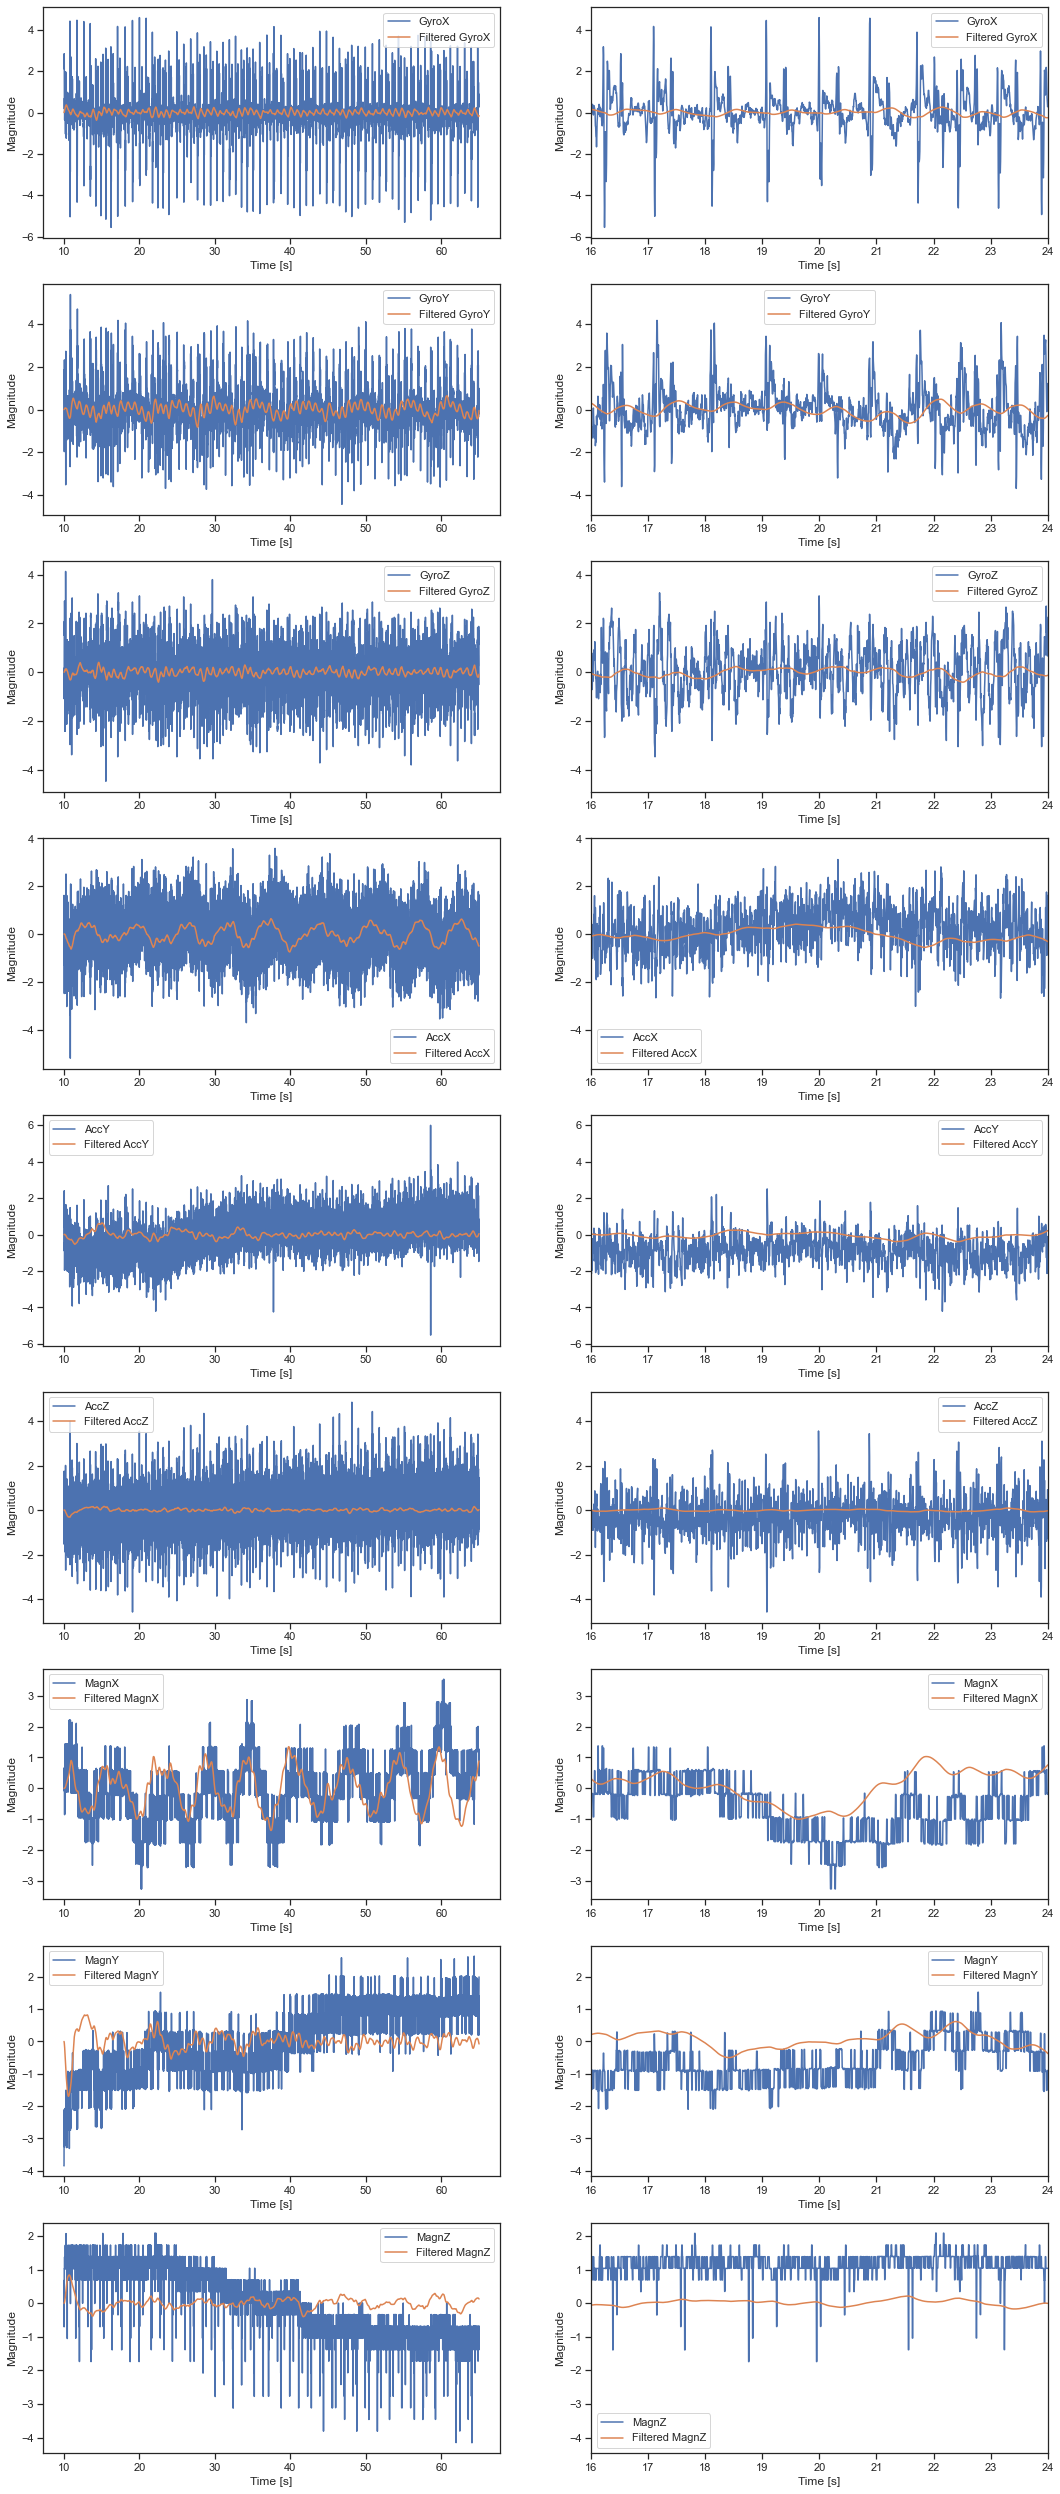

In [207]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j])
        axs[j][i].plot(data["Abs Time"], filtered[j],     label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([16,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")
    

Now , using the filtered signal we want again to test some correlation between the variables; in particular the linear acceleration and the magnetic field along X and the angular velocity in Y and Z

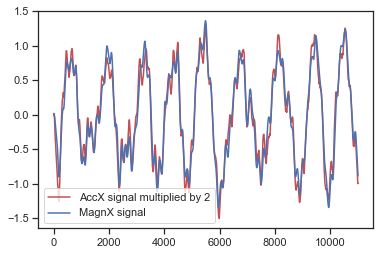

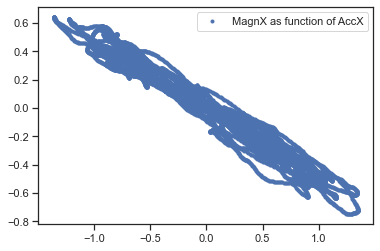

correlation between accX and magnX 
 [[ 1.         -0.97961441]
 [-0.97961441  1.        ]]

 correlation between accX and GyroY 
 [[1.         0.00298533]
 [0.00298533 1.        ]]

 correlation between accX and GyroZ 
 [[1.         0.22206468]
 [0.22206468 1.        ]]

 correlation between magnX and GyroY 
 [[1.         0.03247459]
 [0.03247459 1.        ]]

 correlation between magnX and GyroZ
 [[ 1.         -0.22336552]
 [-0.22336552  1.        ]]

 correlation between GyroZ and GyroY
 [[1.         0.29949721]
 [0.29949721 1.        ]]

 correlation between AccY and AccZ
 [[1.         0.38525939]
 [0.38525939 1.        ]]

 correlation between AccY and MagnZ
 [[ 1.         -0.41062945]
 [-0.41062945  1.        ]]

 correlation between AccZ and MagnZ
 [[ 1.         -0.49694238]
 [-0.49694238  1.        ]]


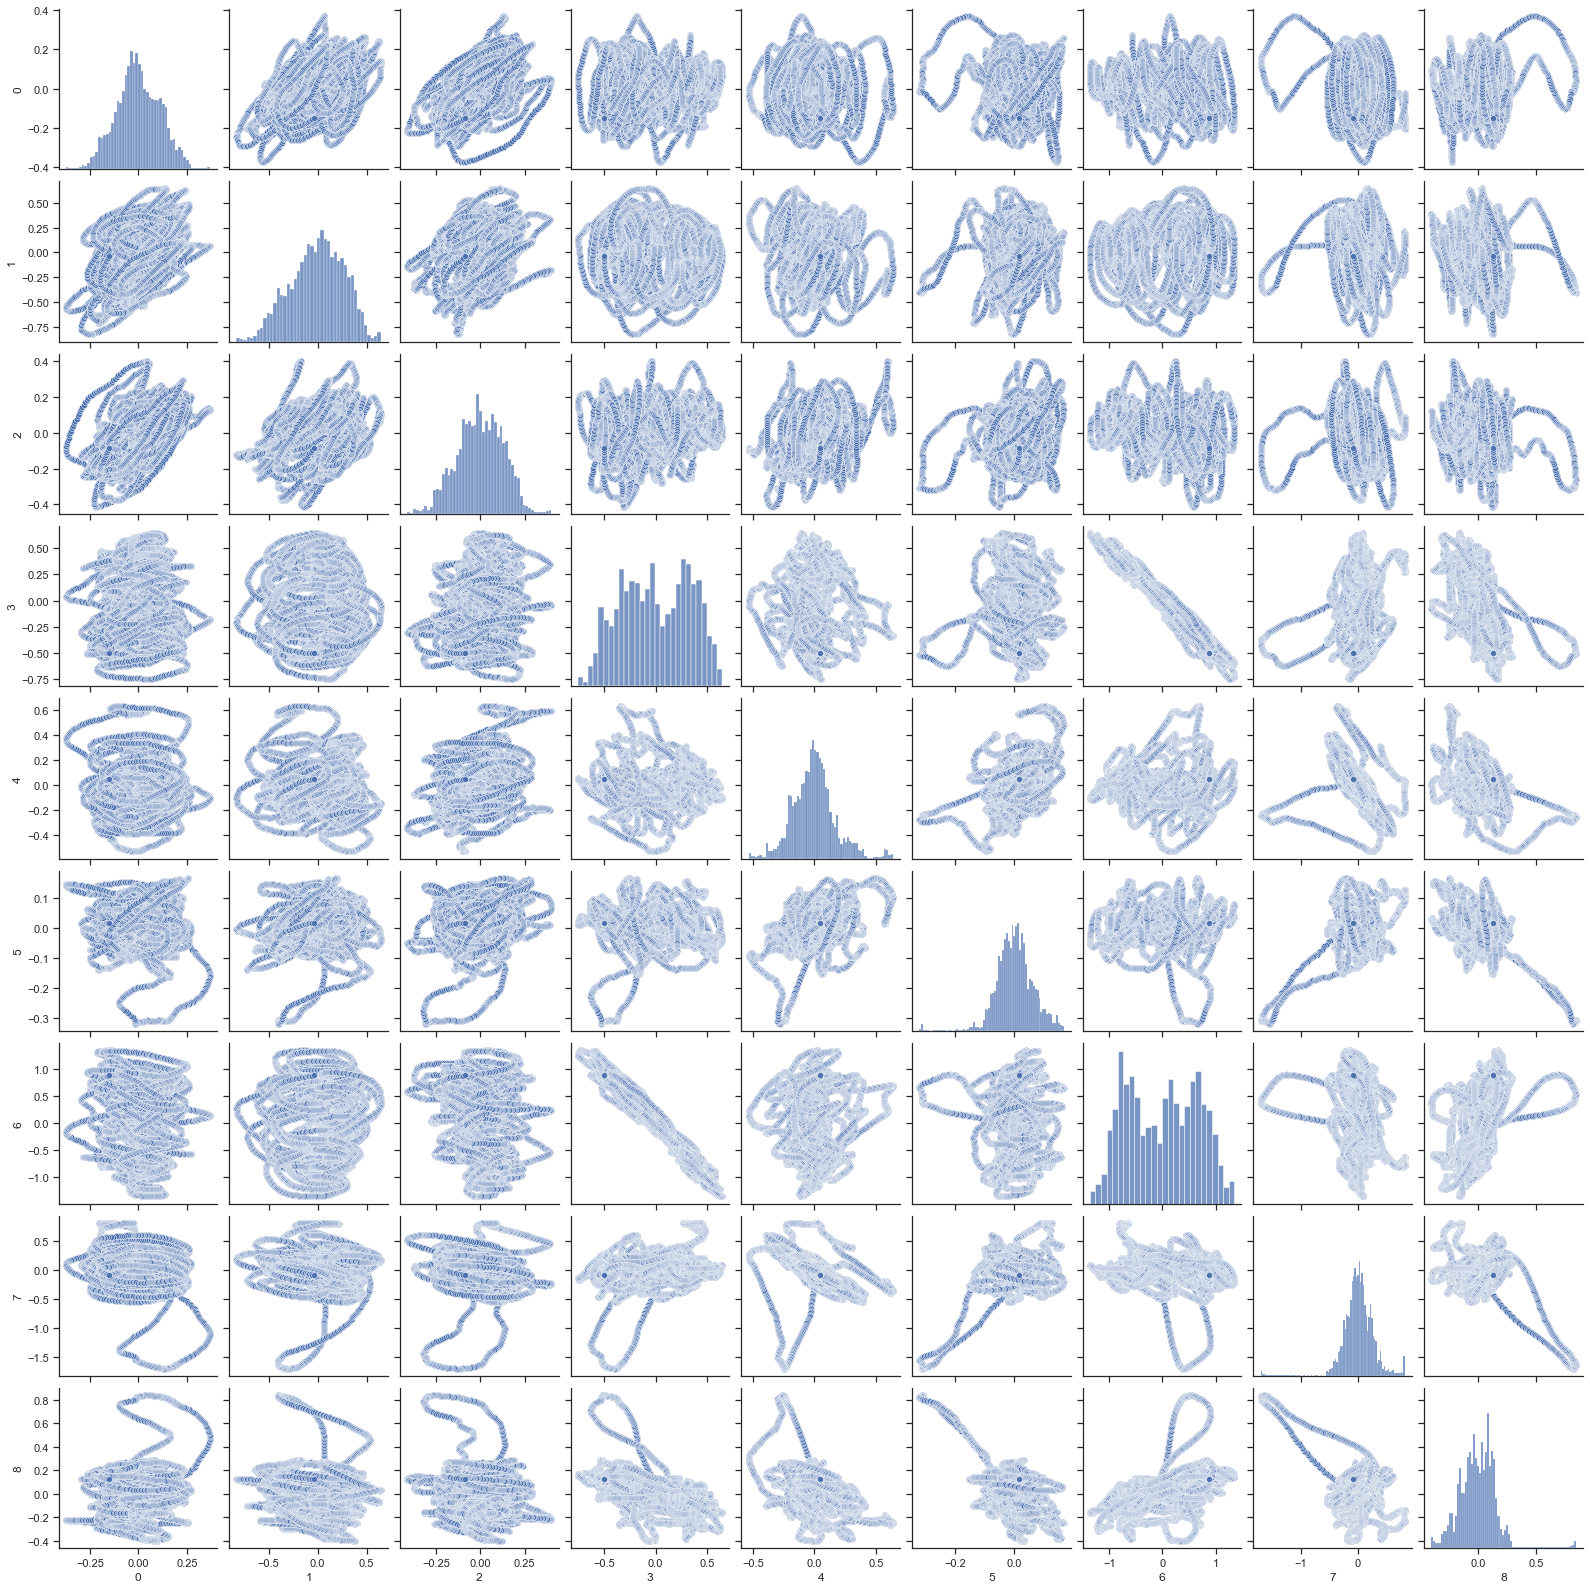

In [205]:
plt.plot(2*filtered[3], c='r', label='AccX signal multiplied by 2')
plt.plot(-filtered[6], c='b', label='MagnX signal')
plt.legend(loc='best')
plt.show()
plt.plot(filtered[6], filtered[3], '.', label='MagnX as function of AccX')
plt.legend(loc='best')
plt.show()

print('correlation between accX and magnX \n',np.corrcoef(filtered[3], y=filtered[6]))
print('\n correlation between accX and GyroY \n',np.corrcoef(filtered[3], y=filtered[1]))
print('\n correlation between accX and GyroZ \n',np.corrcoef(filtered[3], y=filtered[2]))
print('\n correlation between magnX and GyroY \n',np.corrcoef(filtered[6], y=filtered[1]))
print('\n correlation between magnX and GyroZ\n',np.corrcoef(filtered[6], y=filtered[2]))
print('\n correlation between GyroZ and GyroY\n',np.corrcoef(filtered[2], y=filtered[1]))
print('\n correlation between AccY and AccZ\n',np.corrcoef(filtered[4], filtered[5]))
print('\n correlation between AccY and MagnZ\n',np.corrcoef(filtered[4], filtered[8]))
print('\n correlation between AccZ and MagnZ\n',np.corrcoef(filtered[5], filtered[8]))



We find a great correlation between magnX and accX (linear coefficient is -0.98). By the two plots we are also able to see a clear correlation between these two. They are the two cleanest signal so we would like to estimate the respiration rate by analyzing these two variables

The filtered signal has a regular behaviour (oscillating) for the acceleration only in the X direction (we think about it as the direction that goes through the body), for the angular velocity along Y and for the magnetic field we find a regular oscillation in the X direction

In [172]:
#plot filtered spectrum
sig_fft_new = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft_new[i] = fftpack.fft(filtered[i])

power_new = np.abs(sig_fft_new)

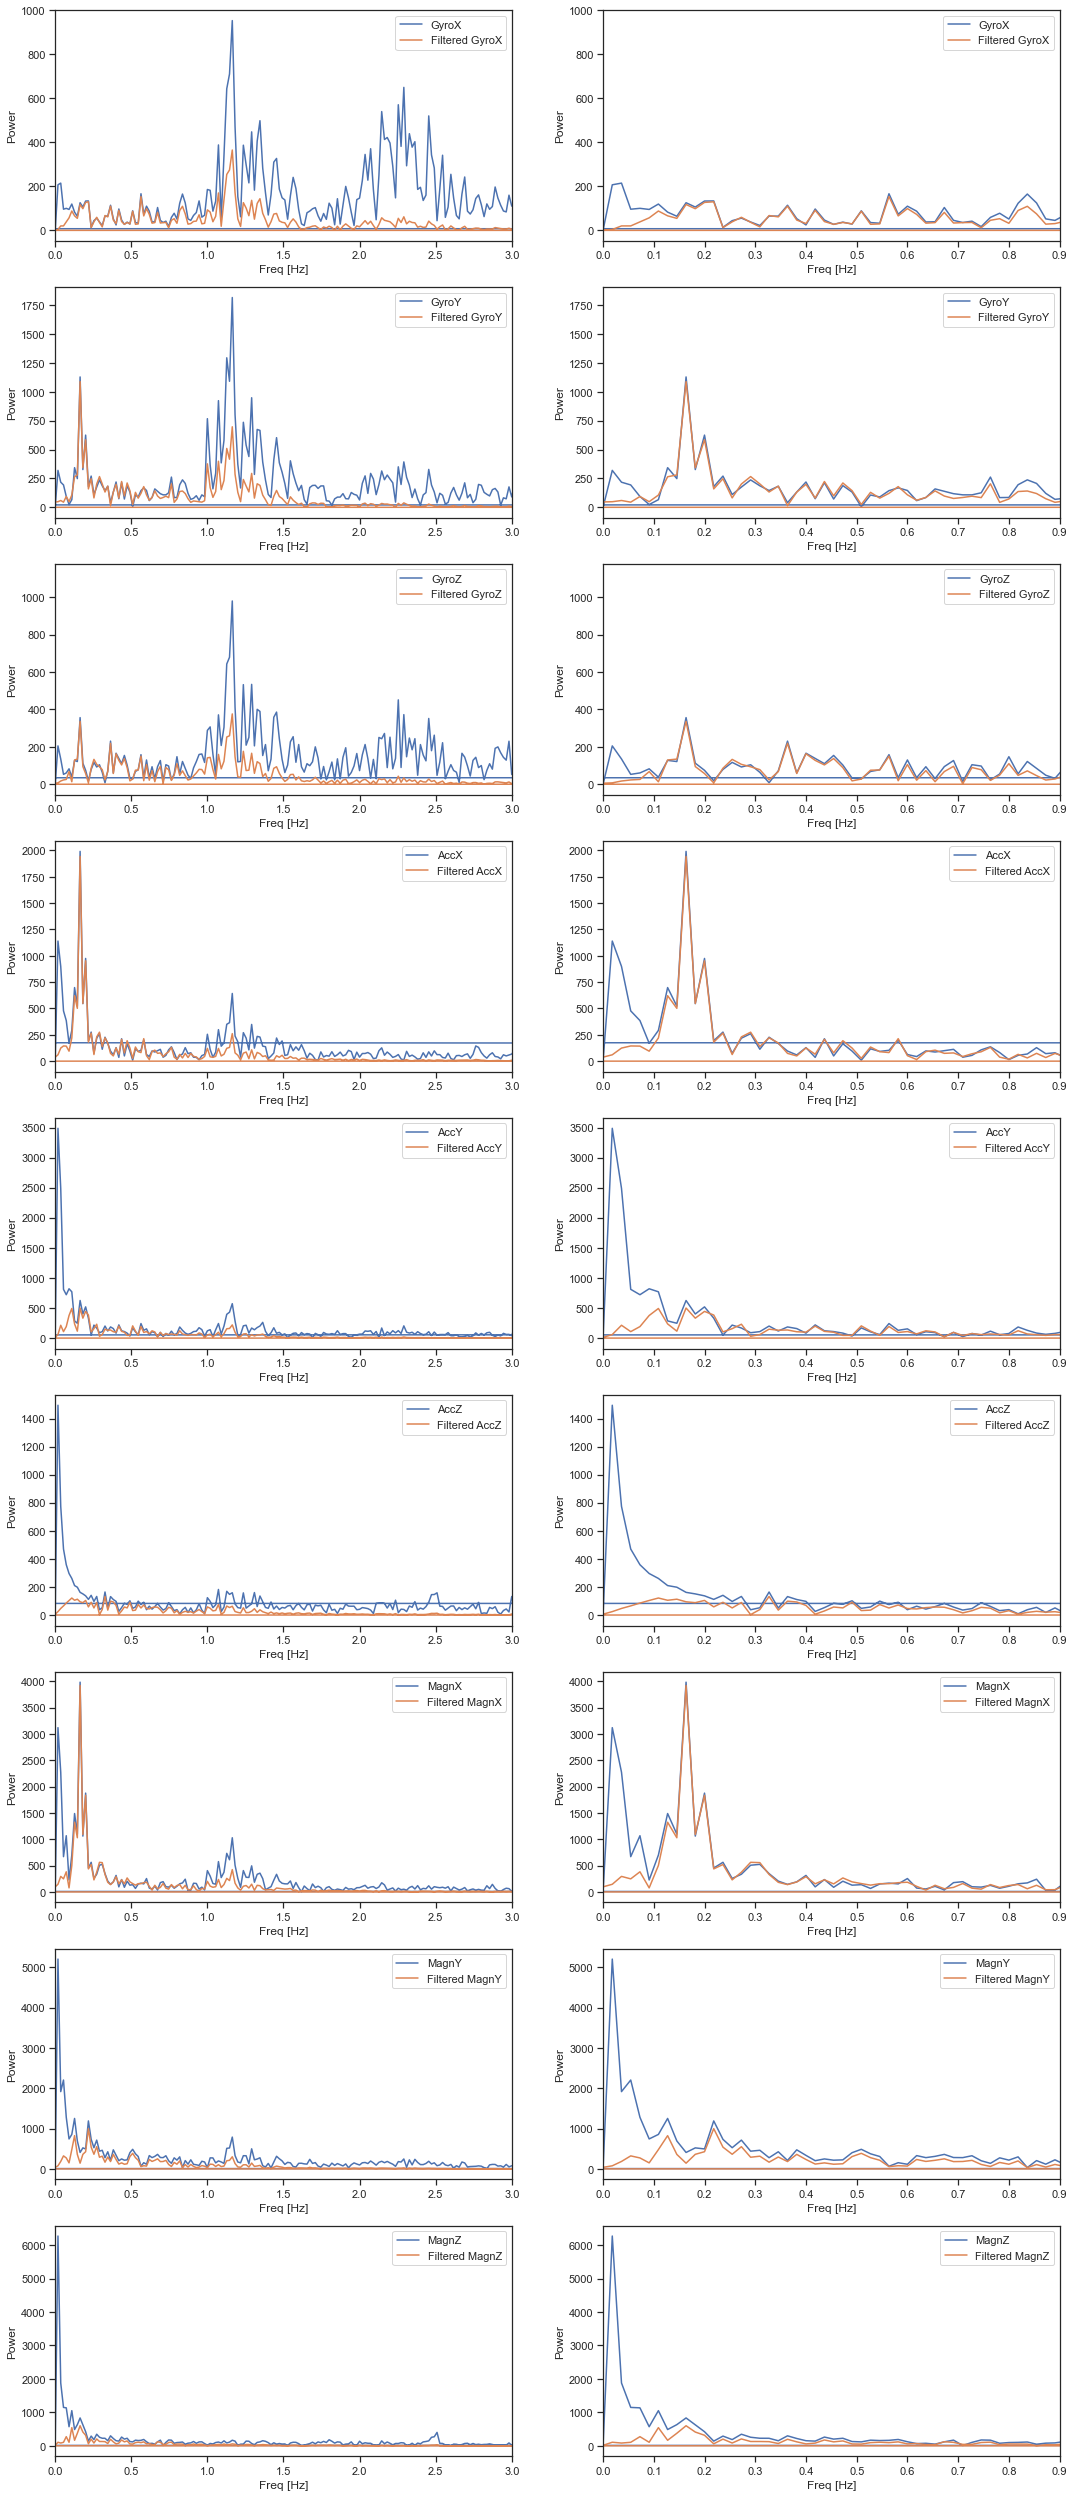

In [173]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],     label=labels[j])
        axs[j][i].plot(sample_freq, power_new[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,0.8])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

We see well the hearth frequence, near 1.2 Hz in almost all the plots. For the respiration rate we see some possible result (the rate is about 12 RPM, so a frequency near 0.2 Hz) in the angular velocities in Y (in particular) and Z. In the acceleration along X is quite evident a peak between 0.1 and 0.2 Hz. Also in the magnetic field along X we see a high peak in that frequency. We can try to estimate the rate by picking the power maximum of the frequencies in a certain window (let's say {0.1,0.3}). 